# B站番剧评分数据分析和番剧推荐，用类型和年份进行用户评分预测

### 明确问题：

    明确要解决的问题：番剧推荐，番剧的产量 
    =>明确需要的数据：剧番id、标题、标签、长评数、短评数、年份、视频链接；用户id，剧番id，评分，评分时间

### 确定验证方案
  
     1）数据获取：爬虫，b站番剧
     2）数据处理
     3）数据展示和分析
     4）推荐算法+预测算法

### 设计预测模型
        
     1）新用户：基于内容的推荐
     2）老用户：基于协同过滤的推荐
     3）根据类型和时间进行新番的评分预测

### 实施流程：

    1、获取数据：爬虫
    2、了解数据：数据处理和展示
    3、构建模型：推荐，预测
 
#### 1 获取数据-爬虫：

    爬虫存在的问题：
        1）网络问题，会导致一些内容没有爬取到，而没存入csv中；
        2）可能有些特殊情况，比如评论时间的问题等，格式不一致或者其他情况，导致未爬取成功；
        这些情况导致的数据缺失问题，由一开始的基数进行弥补，即为了获取较多的数据，一开始选取的番剧数量也足够多。

    爬虫遇到的问题&解决方法：

| 出现的问题 | 猜测原因 | 解决方法 |
|: ------ |: ------ | :------ |
| 用request获取页面code无法获取真正的内容 | 页面是js动态加载的 | 借助selenium库，利用模拟浏览器模式打开网页获取内容<br/>```chrome_options = webdriver.ChromeOptions()<br/>#使用headless无界面浏览器模式```<br/>```chrome_options.add_argument('--headless') # 增加无界面选项```<br/>```chrome_options.add_argument('--disable-gpu') #如果不加这个选项，有时定位会出现问题```<br/>```#启动浏览器```<br/>```driver =webdriver.Chrome(options=chrome_options)``` <br/>```driver.get(url)```<br/>```content = driver.page_source```<br/>```soup = BeautifulSoup(content, 'lxml')```<br/>```driver.close()```<br/>|
| 突然访问失败，网页浏览也是 | ip被限制 | 设置随机等待时间，<br/>```rand_seconds = random.choice([1, 3]) + random.random()```<br/>  ```sleep(rand_seconds) ```|
| 重复爬取第一页内容 | 反爬机制 | 在更改url获取页面code的时候，	<br/>使用 driver.refresh()进行页面刷新 |
| url不变，下滑页面变化 | 动态加载 | ``` # 滑动动态加载页面，让浏览器执行简单的js代码```<br/> ```  js = "window.scrollTo(0,document.body.scrollHeight)"```<br/>``` driver.execute_script(js)``` |
| 长评论和短评论的分配 | -- | 按照比例分配，选取爬取评分的数量的基准是参考最少的评论总数 |

#### 2 了解数据-数据处理和展示

     数据处理：
| 爬虫过程 | 获得爬虫数据之后 | 
|:------ |:------ |
|  1\对重复爬取的link进行去重；<br/>2\对评论时间的处理，把只有月日、“昨天”，“x小时前”，<br/>“x分钟前”这样的非标准日期进行转化，变成年月日的日期形式；<br/>3\对于不存在评论的番剧已经进行跳过处理，不会爬取； | 1\对于还有可能的存在是数据重复进行处理<br/>2\数据标准化（对于番剧信息里面的'year'进行处理；<br/>提取评分和番剧信息里面的年，月，以便画图分析） |
    
    数据展示：
        统计：一共有多少番剧，一共有多少用户进行评分，
        柱状图：随着时间评分平均值的分布，总数的分布，剧番数量的分布；按月份的分布；每个番的每年或者每月评分分布情况；

        
#### 3 构建模型
    推荐：
    预测：

# 导包

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format ='svg'#为了画图更美观

# 数据标准化

In [2]:
#导入电影信息文件
video = pd.read_csv('video_data.csv')
video.shape

(380, 7)

## 检查和去重

In [3]:
# 去重
video_df=video.drop_duplicates()
video_df.shape

(380, 7)

In [4]:
video_df.head()

,v_id,title,genres,year,long_comm,short_comm,detail_link
0,BV1Lb4113744,鬼灭之刃,"漫画改,战斗,热血,声控,",2019年4月7日,573,118132,http://www.bilibili.com/bangumi/media/md22718131/
1,BV1as411p7ae,工作细胞,"搞笑,战斗,日常,声控,",2018年7月8日,236,20767,http://www.bilibili.com/bangumi/media/md102392/
2,BV1pV411o7yD,辉夜大小姐想让我告白？～天才们的恋爱头脑战～,"搞笑,校园,恋爱,漫画改,",2020年4月12日,211,21411,http://www.bilibili.com/bangumi/media/md28228367/
3,BV11x411q7iu,欢迎来到实力至上主义的教室,"小说改,校园,",2017年7月13日,309,21988,http://www.bilibili.com/bangumi/media/md6339/
4,BV1ox411Q7V7,埃罗芒阿老师,"小说改,搞笑,恋爱,",2017年4月9日,152,15279,http://www.bilibili.com/bangumi/media/md5997/


In [5]:
rating = pd.read_csv('rating_data.csv')
rating.shape

(77843, 4)

In [6]:
rating.head()
# 这里可以看到发布评价的时间信息，本来计划做评价时间分布情况的展示，
# 但是由于仅爬取了部分评价，而且大部分都是近期评价，因此，这种信息是无用的，无法看出真正的评价时间分布情况趋势

,user_id_name,v_id,rating,rating_time
0,Canbuno,BV1Lb4113744,5,2019-12-29
1,狼と十三香,BV1Lb4113744,5,2020-05-09
2,白开水酱777,BV1Lb4113744,5,2020-05-09
3,怪味菌qeq,BV1Lb4113744,5,2020-05-10
4,喵夕夕,BV1Lb4113744,5,2020-05-10


In [7]:
rating_df=rating.drop('rating_time',axis=1)
# 去重
rating_df = rating_df.drop_duplicates()
rating_df.shape

(77741, 3)

## 番剧信息里面的'year'进行处理

In [8]:
video_df['year']

0        2019年4月7日
1        2018年7月8日
2       2020年4月12日
3       2017年7月13日
4        2017年4月9日
          ...     
375      2009年4月2日
376     2007年7月26日
377     2016年10月4日
378      2015年4月2日
379    1999年10月16日
Name: year, Length: 380, dtype: object

In [9]:
video_df['time']=video_df['year'].apply(lambda x: x.replace('年','-').replace('月','-').replace('日',''))
video_df['time']

0        2019-4-7
1        2018-7-8
2       2020-4-12
3       2017-7-13
4        2017-4-9
          ...    
375      2009-4-2
376     2007-7-26
377     2016-10-4
378      2015-4-2
379    1999-10-16
Name: time, Length: 380, dtype: object

In [10]:
video_df['v_year']=video_df['time'].apply(lambda x: x.split('-')[0])
video_df['v_month']=video_df['time'].apply(lambda x: x.split('-')[1])

In [11]:
video_df.head(2)

,v_id,title,genres,year,long_comm,short_comm,detail_link,time,v_year,v_month
0,BV1Lb4113744,鬼灭之刃,"漫画改,战斗,热血,声控,",2019年4月7日,573,118132,http://www.bilibili.com/bangumi/media/md22718131/,2019-4-7,2019,4
1,BV1as411p7ae,工作细胞,"搞笑,战斗,日常,声控,",2018年7月8日,236,20767,http://www.bilibili.com/bangumi/media/md102392/,2018-7-8,2018,7


In [12]:
# 计算每个番剧真正被评论的次数
video_df['rating_count_ac'] = video_df.long_comm+video_df.short_comm
video_df.head(2)

,v_id,title,genres,year,long_comm,short_comm,detail_link,time,v_year,v_month,rating_count_ac
0,BV1Lb4113744,鬼灭之刃,"漫画改,战斗,热血,声控,",2019年4月7日,573,118132,http://www.bilibili.com/bangumi/media/md22718131/,2019-4-7,2019,4,118705
1,BV1as411p7ae,工作细胞,"搞笑,战斗,日常,声控,",2018年7月8日,236,20767,http://www.bilibili.com/bangumi/media/md102392/,2018-7-8,2018,7,21003


In [13]:
# 取需要的属性列
new_video_df = video_df.iloc[:,[0,1,2,8,9,10]]
new_video_df.head(2)

,v_id,title,genres,v_year,v_month,rating_count_ac
0,BV1Lb4113744,鬼灭之刃,"漫画改,战斗,热血,声控,",2019,4,118705
1,BV1as411p7ae,工作细胞,"搞笑,战斗,日常,声控,",2018,7,21003


In [14]:
# 计算每个番剧实际爬取的评论次数
rating_counts = pd.DataFrame(rating_df.groupby('v_id').count()['rating'])
# rating_counts.rename(columns={'ratings':'ratingCount'},inpalce=True)
rating_counts.columns=['rating_count']
rating_counts.head()

,rating_count
v_id,
BV11t411s776,241
BV11t411s7Ay,241
BV11x411q7iu,241
BV12e411s7bN,241
BV12s41167vE,241


In [15]:
# 合并数据,video_total 只是video的一些信息，没有user-video-rating的部分
video_total = pd.merge(new_video_df, rating_counts, on='v_id')
video_total.head()

,v_id,title,genres,v_year,v_month,rating_count_ac,rating_count
0,BV1Lb4113744,鬼灭之刃,"漫画改,战斗,热血,声控,",2019,4,118705,241
1,BV1as411p7ae,工作细胞,"搞笑,战斗,日常,声控,",2018,7,21003,241
2,BV1pV411o7yD,辉夜大小姐想让我告白？～天才们的恋爱头脑战～,"搞笑,校园,恋爱,漫画改,",2020,4,21622,241
3,BV11x411q7iu,欢迎来到实力至上主义的教室,"小说改,校园,",2017,7,22297,241
4,BV1ox411Q7V7,埃罗芒阿老师,"小说改,搞笑,恋爱,",2017,4,15431,241


In [16]:
# 获取每个的平均评分
rating_means = pd.DataFrame(rating_df.groupby('v_id').mean()['rating'])
rating_means.columns = ['rating_mean']
rating_means.head()

,rating_mean
v_id,
BV11t411s776,4.966805
BV11t411s7Ay,4.950207
BV11x411q7iu,4.800830
BV12e411s7bN,4.900415
BV12s41167vE,4.838174


In [17]:
# 合并数据
video_total = pd.merge(video_total, rating_means, on='v_id')
# video_total = video_total.sort_values(by="rating_count", ascending=False)
video_total.head(2)

,v_id,title,genres,v_year,v_month,rating_count_ac,rating_count,rating_mean
0,BV1Lb4113744,鬼灭之刃,"漫画改,战斗,热血,声控,",2019,4,118705,241,4.958506
1,BV1as411p7ae,工作细胞,"搞笑,战斗,日常,声控,",2018,7,21003,241,4.950207


<function matplotlib.pyplot.show>

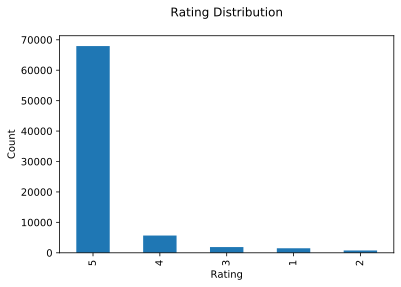

In [18]:
# 评分分布情况
rating_df.rating.value_counts(sort=True).plot(kind='bar')
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
# plt.savefig('rating.png',bbox_inches='tight')
plt.show

In [19]:
# 每年番剧数
video_total['v_year'].value_counts()

2019    50
2017    43
2018    41
2016    37
2015    26
2020    24
2013    20
2014    19
2012    17
2011    12
2010     6
2008     5
2006     5
2009     4
2007     4
2005     4
1999     1
1979     1
2003     1
1996     1
2000     1
1940     1
1998     1
Name: v_year, dtype: int64

Text(0, 0.5, 'counts')

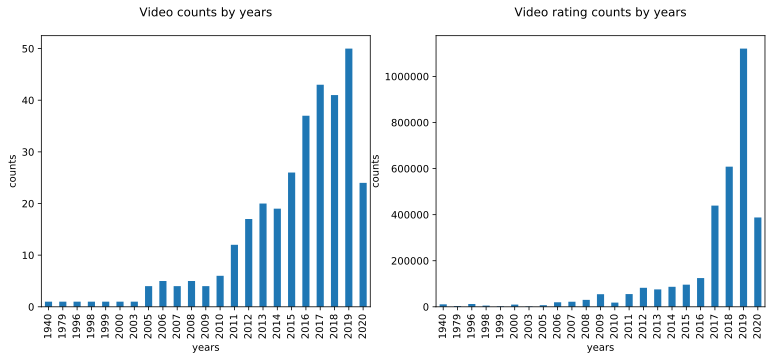

In [20]:
# 可视化每年番剧数量和每年番剧被评论数
plt.figure(figsize=(13,5))
# 每年番剧数
plt.subplot(1,2,1)
video_total.groupby('v_year')['rating_count_ac'].count().plot(kind='bar')
plt.title('Video counts by years\n')
plt.xlabel('years')
plt.ylabel('counts')
# 每年评论数
plt.subplot(1,2,2)
video_total.groupby('v_year')['rating_count_ac'].sum().plot(kind='bar')
plt.title('Video rating counts by years\n')
plt.xlabel('years')
plt.ylabel('counts')

In [21]:
# 让字典按key重新排序，返回字典
def dic_sort_by_key(dic):
    new_dic = {}
    ke = sorted(dic.keys())
    for k in ke:
        new_dic[k]=dic[k]
    return new_dic

# 计算得到df，列名是年份，行名是月份，为了下面画图
def get_ym_count(df,col1,col2,col3):
    dic_count ={}
    for i in set(df[col1]): # 在year里
        m = df[df[col1].isin([i])].groupby(col2)[col3].count() # 在当前year的month，count计算行数，也就是番剧数
        # print(m)
        # print(m.index.values)
        a = m.index.values
        b = [int(x) for x in a]
        month_count = []
        for j in range(1,13):
            if j in b:
                month_count.append(m[str(j)])
            else:
                month_count.append(0)
        dic_count[i]=month_count
    new_dic = dic_sort_by_key(dic_count)
    return pd.DataFrame(new_dic)

def get_ym_Rcount(df,col1,col2,col3):
    dic_count ={}
    for i in set(df[col1]): # 在year里
        m = df[df[col1].isin([i])].groupby(col2)[col3].sum() # 在当前year的month计算评论总数
        # print(m)
        # print(m.index.values)
        a = m.index.values
        b = [int(x) for x in a]
        month_count = []
        for j in range(1,13):
            if j in b:
                month_count.append(m[str(j)])
            else:
                month_count.append(0)
        dic_count[i]=month_count
    new_dic = dic_sort_by_key(dic_count)
    return pd.DataFrame(new_dic)

# month_count
dic_count = get_ym_count(video_total,'v_year','v_month','rating_count_ac') # rating_count这可以定义为别的，只要是属于video_total里面的除了year和month的
dic_Rcount = get_ym_Rcount(video_total,'v_year','v_month','rating_count_ac') # rating_count这必须定义为这个
# X = np.array(dic_count.keys())
# print(X)
dic_count

,1940,1979,1996,1998,1999,2000,2003,2005,2006,2007,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,0,0,1,0,0,0,0,1,1,0,...,2,2,3,4,2,4,7,13,12,15
1,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,2,0,0,0,1
3,0,1,0,1,0,0,0,1,2,1,...,4,5,4,6,8,9,11,8,9,8
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
6,0,0,0,0,0,0,0,0,1,1,...,2,1,3,3,8,13,9,12,12,0
7,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,3,0,1,0
9,0,0,0,0,1,1,1,2,1,1,...,3,7,9,6,8,6,12,8,11,0


In [22]:
dic_Rcount

,1940,1979,1996,1998,1999,2000,2003,2005,2006,2007,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,0,0,12205,0,0,0,0,1678,3274,0,...,14529,8572,10399,9571,15872,14383,17293,219235,320406,312224
1,10821,0,0,0,0,0,0,0,0,0,...,0,1236,0,0,0,0,0,0,10158,0
2,0,0,0,0,0,0,0,0,0,3782,...,0,0,0,0,0,23444,0,0,0,14463
3,0,3114,0,5320,0,0,0,630,4844,2434,...,22847,25530,22232,40002,32254,36287,140371,43772,214831,60921
4,0,0,0,0,0,0,0,0,0,0,...,0,0,3628,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,38660,0
6,0,0,0,0,0,0,0,0,1336,2207,...,1988,3874,4965,13732,32587,22140,112076,132219,261360,0
7,0,0,0,0,0,0,0,0,0,0,...,2153,0,0,0,0,12696,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,2923,0,0,0,0,10521,0,3155,0
9,0,0,0,0,2313,9533,1672,4779,10160,13672,...,13745,40438,34450,23376,15366,9474,155365,213065,261465,0


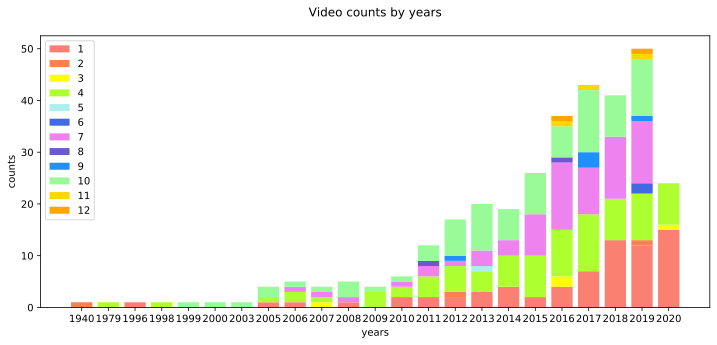

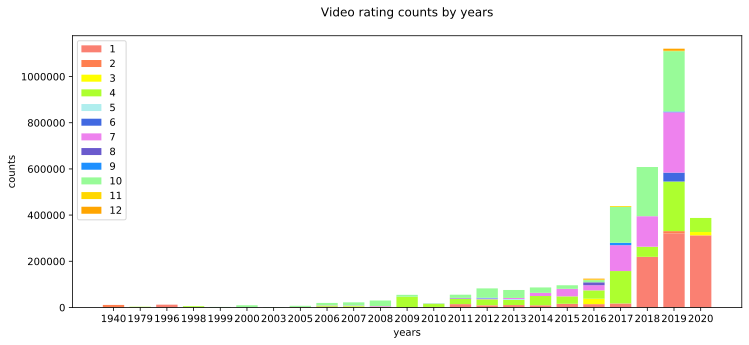

In [23]:
#堆叠条形图
# import matplotlib.pyplot as plt
# import numpy as np
# %matplotlib inline

def plot_StackBar(dic_count,title,xlabel,ylabel,index,colors,labels):
    plt.figure(figsize=(12,5))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    data_pre = np.array([])
    # 这个循环代表一层一层的叠上去
    # 注意x（index）,和 每层堆叠的值（data），长度一定要一致，否则会出错
    for i in range(12):
        data = np.array(dic_count.iloc[i,:])
    #     print(data)
    #     print(colors[i])
    #     print(labels[i])
        if i == 0:
            plt.bar(index, data ,  color = colors[i], label = str(labels[i]))
            data_pre = data
        else:
            plt.bar(index, data , bottom = data_pre, color = colors[i], label = str(labels[i]))
            data_pre += data #叠起来
    plt.legend()

index= np.array(dic_count.columns)
colors = ['#FA8072','#FF7F50','#FFFF00','#ADFF2F','#AFEEEE','#4169E1','#EE82EE','#6A5ACD','#1E90FF','#98FB98','#FFD700','#FFA500']
labels = np.arange(1,13)
title = 'Video counts by years\n'
xlabel= 'years'
ylabel = 'counts'
plot_StackBar(dic_count,title,xlabel,ylabel,index,colors,labels)

index= np.array(dic_Rcount.columns)
colors = ['#FA8072','#FF7F50','#FFFF00','#ADFF2F','#AFEEEE','#4169E1','#EE82EE','#6A5ACD','#1E90FF','#98FB98','#FFD700','#FFA500']
labels = np.arange(1,13)
title = 'Video rating counts by years\n'
xlabel= 'years'
ylabel = 'counts'
plot_StackBar(dic_Rcount,title,xlabel,ylabel,index,colors,labels)

# 分布类似，原因，番剧放映多的月份或者年份，评论数也自然多，符合一般逻辑思考
# 第二张图是依据番剧上映的时间，对不同年份的所有番剧计算到“目前为止”（爬虫爬取的时刻为止）的评论总数

# 基于协同过滤的推荐（参考电影的案例）

In [ ]:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD

In [24]:
# 构建要使用与筛选的番剧信息
combine_v = pd.merge(rating_df,rating_counts,on='v_id')
combine_v = combine_v.dropna()
combine_v.head()

,user_id_name,v_id,rating,rating_count
0,Canbuno,BV1Lb4113744,5,241
1,狼と十三香,BV1Lb4113744,5,241
2,白开水酱777,BV1Lb4113744,5,241
3,怪味菌qeq,BV1Lb4113744,5,241
4,喵夕夕,BV1Lb4113744,5,241


In [25]:
combine_v.shape

(77741, 4)

In [26]:
# 查看评论数的种类
set(combine_v['rating_count'])

{220, 221, 238, 239, 240, 241}

In [27]:
# 计算70%评论数为多少用以筛选
combine_v.rating_count.quantile(0.7)

241.0

In [28]:
popularity_threshold = combine_v.rating_count.quantile(0.7)
# 根据位置进行筛选
rating_popular_v = combine_v.query('rating_count >= @popularity_threshold')
rating_popular_v.head()

,user_id_name,v_id,rating,rating_count
0,Canbuno,BV1Lb4113744,5,241
1,狼と十三香,BV1Lb4113744,5,241
2,白开水酱777,BV1Lb4113744,5,241
3,怪味菌qeq,BV1Lb4113744,5,241
4,喵夕夕,BV1Lb4113744,5,241


In [29]:
rating_popular_v.shape

(64106, 4)

In [30]:
# 将表格转化为2D矩阵，pivot对数据表进行重塑
video_pivot = rating_popular_v.pivot(index='v_id',columns='user_id_name',values='rating').fillna(0)
video_pivot.shape

(266, 50997)

In [31]:
video_pivot

user_id_name,------简凛----,-----夕雾-----,-----无名,----Belief----,----en----,----时崎狂三----,----鲁迅,---Lin___,---YANG--,---_---_-,...,龙龙龙龙龙龙521,龚大将军,龚玥晟,龟苓膏のあにき,龟龟pc8c,나사랑당신와,눈口눈,신의탑,秊羙,（ゝω・）
v_id,,,,,,,,,,,,,,,,,,,,,
BV11t411s776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BV11t411s7Ay,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BV11x411q7iu,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BV12e411s7bN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BV12s41167vE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BV1yJ411R7je,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BV1yx411Q7dv,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BV1zJ411L7Vv,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
# 选出评分最多的电影id
v_most = rating_df.groupby('v_id').count().sort_values('rating',ascending=False).index[0]
video_total[video_total.v_id==v_most]
video_total[video_total.title=='碧蓝之海']
v_most ='BV13s411J7jn'

In [81]:
def get_movie(df_movie,movie_list):
    #根据番剧ID获取番剧的详细信息
    df_movieId = pd.DataFrame(movie_list,index=np.arange(len(movie_list)),columns=['v_id'])
    corr_movies = pd.merge(df_movieId,df_movie,on='v_id')
    return corr_movies
def pearson_method(df_movie, pivot, movie, num):
    # 获取目标番剧属性
    bones_ratings = pivot.T[movie]
#     print(bones_ratings)
    similar_to_bones = pivot.corrwith(bones_ratings)
#     print(similar_to_bones)
    corr_bones = pd.DataFrame(similar_to_bones,columns=['pearson'])
    corr_bones.dropna(inplace=True)
    # 相关性与评论数合并
    corr_summary = corr_bones.join(df_movie[['v_id','rating_count']].set_index('v_id'))
    # 筛选出对应数量的高关联性番剧
    movie_list = corr_summary[corr_summary['rating_count']>100].sort_values('pearson',ascending=False).index[:num].tolist()
    return movie_list

In [82]:
# 获取电影ID列表
video_list = pearson_method(video_total,video_pivot,v_most,6)
# print(video_list)
corr_movies = get_movie(video_total,video_list)
corr_movies

,v_id,title,genres,v_year,v_month,rating_count_ac,rating_count,rating_mean


In [55]:
def knn_method(movie_pivot,movie,num):
    # 压缩稀疏矩阵
    movie_pivot_matrix = csr_matrix(movie_pivot.values)
    # 用k近邻的算法是“brute”，指定“metric=cosine”，计算余弦相似度
#     蛮力实现(brute)：计算预测样本到所有训练集样本的距离，然后选择最小的k个距离即可得到K个最邻近点。缺点在于当特征数比较多、样本数比较多的时候，算法的执行效率比较低;
    model_knn = NearestNeighbors(metric='cosine',algorithm='brute')
    model_knn.fit(movie_pivot_matrix)
    distance,indices = model_knn.kneighbors(movie_pivot.loc[[movie],:].values.reshape(1,-1),n_neighbors=num)
    movie_list = movie_pivot.iloc[indices[0],:].index
    return movie_list

v_list = knn_method(video_pivot,v_most,6)
corr_movies = get_movie(video_total,v_list)
corr_movies

,v_id,title,genres,v_year,v_month,rating_count_ac,rating_count,rating_mean
0,BV13s411J7jn,碧蓝之海,"搞笑,校园,社团,运动,",2018,7,24859,241,4.979253
1,BV1Cx411F7La,中二病也要谈恋爱！,"恋爱,",2012,10,5623,241,4.966805
2,BV19s411N7aW,剧场版 中二病也要谈恋爱！ -Take On Me-,"小说改,恋爱,",2018,7,11402,241,4.983402
3,BV1Yx411S7y9,从零开始的魔法书,"小说改,奇幻,魔法,架空,",2017,4,2232,241,4.887967
4,BV1Ax411G7s9,属性咖啡厅,"萌系,少女,日常,漫画改,",2017,10,6697,241,4.946058
5,BV1os411H7wm,Angels of Death,"恋爱,游戏改,冒险,",2018,7,19081,241,4.950207


In [56]:
def SVD_method(movie_pivot,movie,num):
    SVD = TruncatedSVD(n_components=12,random_state=17)
    matrix = SVD.fit_transform(movie_pivot.values)
    movie_SVD = pd.DataFrame(matrix,index=movie_pivot.index).T
    corr= movie_SVD.corr()
    movie_list = corr.sort_values(movie,ascending=False).index[0:num].tolist()
    return movie_list
v_list = SVD_method(video_pivot,v_most,6)
corr_movies = get_movie(video_total,v_list)
corr_movies

,v_id,title,genres,v_year,v_month,rating_count_ac,rating_count,rating_mean
0,BV13s411J7jn,碧蓝之海,"搞笑,校园,社团,运动,",2018,7,24859,241,4.979253
1,BV1Zs41187TW,猫咪日常,"漫画改,萌系,日常,泡面,",2017,1,2111,241,4.904564
2,BV1eW41127k1,邻家索菲,"萌系,漫画改,",2018,10,5083,241,4.995851
3,BV1Cx411F7La,中二病也要谈恋爱！,"恋爱,",2012,10,5623,241,4.966805
4,BV1TJ411G7y5,因为太怕痛就全点防御力了,"小说改,穿越,奇幻,萌系,",2020,1,50764,241,4.979253
5,BV1bW411B7v8,爱吃拉面的小泉同学,"治愈,美食,漫画改,",2018,1,3021,241,4.775934


# 基于surprise的两种推荐算法的实现

In [71]:
# 协同过滤方法
import os
from surprise import KNNBaseline
import io
from surprise import Dataset

# step 1 : train model
def TrainModel():
    data = Dataset.load_builtin('ml-100k')
    trainset = data.build_full_trainset()
    # use pearson_baseline to compute similarity
    sim_options = {'name' : 'pearson_baseline', 'user_based' : False}
    algo = KNNBaseline(sim_options=sim_options)
    # train
    algo.fit(trainset)
    return algo

# step 2 : get id_name and name_id
def Get_Dict():
    file_name = os.path.expanduser('~/.surprise_data/ml-100k/ml-100k/u.item')
    id_name = {}
    name_id = {}
    with open(file_name, 'r', encoding='ISO-8859-1') as f:
        for line in f:
            line = line.split('|')
            id_name[line[0]] = line[1]
            name_id[line[1]] = line[0]
    return id_name, name_id

# step 3 : recommend movies based on the model
def RecommendMovie(movieName, algo, id_name, name_id, recommendNum):
    # get movie's raw id 
    raw_id = name_id[movieName]
    # translate raw_id to inner_id
    inner_id = algo.trainset.to_inner_iid(raw_id)
    # recommend movies
    recommendations = algo.get_neighbors(inner_id, recommendNum)
    # translate inner_id to raw_id
    raw_ids = [algo.trainset.to_raw_iid(inner_id) for inner_id in recommendations]
    # get movie name
    movies = [id_name[raw_id] for raw_id in raw_ids]
    for movie in movies:
        print(movie)

if __name__ == '__main__':
    id_name, name_id = Get_Dict()
    algo = TrainModel()
    showMovies = RecommendMovie('Toy Story (1995)', algo, id_name, name_id, 10)
